In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import evaluate
from huggingface_hub import create_repo
import warnings
import re
warnings.filterwarnings("ignore")

In [2]:
## Load the Credit Card Customer Data from Hugging Face Datasets
customer_data = pd.DataFrame(load_dataset("ModSpecialization/Credit_Card_Customer_Data", split="train"))
terminal_data = pd.DataFrame(load_dataset("ModSpecialization/Credit_Card_Terminal_Dataset", split="train"))
customer_termimnal_data = pd.DataFrame(load_dataset("ModSpecialization/Customer_Terminal_Dataset", split="train"))
credit_card_transaction_data = pd.DataFrame(load_dataset("ModSpecialization/Credit_Card_Transaction_Dataset", split="train"))

In [3]:
print(credit_card_transaction_data.info())
print(customer_data.info())
print(terminal_data.info())
print(customer_termimnal_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer Id             7400 non-null   object 
 1   Terminal Id             7400 non-null   object 
 2   Transaction Amount ($)  7400 non-null   float64
 3   Transaction Time        7400 non-null   object 
 4   Is Fraud                7400 non-null   object 
 5   Fraud Reason            2118 non-null   object 
dtypes: float64(1), object(5)
memory usage: 347.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Customer Id                      1000 non-null   object
 1   Avg transaction pattern          1000 non-null   int64 
 2   CardholderAge                    1000 non-null   int64 
 

In [ ]:

# Replace spaces with underscores in all DataFrame column names
customer_data.columns = customer_data.columns.str.replace(r"\s+", '_', regex=True)
terminal_data.columns = terminal_data.columns.str.replace(r"\s+", '_', regex=True)
customer_termimnal_data.columns = customer_termimnal_data.columns.str.replace(r"\s+", '_', regex=True)
credit_card_transaction_data.columns = credit_card_transaction_data.columns.str.replace(r"\s+", '_', regex=True)

# customer_data.to_csv("customer_data.csv", index=False)
# terminal_data.to_csv("terminal_data.csv", index=False)
# customer_termimnal_data.to_csv("customer_terminal_data.csv", index=False)
# credit_card_transaction_data.to_csv("credit_card_transaction_data.csv", index=False)

## Merge the datasets for training and test dataset
merged_dataset = credit_card_transaction_data \
    .merge(customer_data, on="Customer_Id", how="left") \
    .merge(terminal_data, on="Terminal_Id", how="left") \
    .merge(customer_termimnal_data, on=["Customer_Id", "Terminal_Id"], how="left") \
    .sample(n=len(credit_card_transaction_data), random_state=42)

# Reset the index of the merged dataset
merged_dataset = merged_dataset.reset_index(drop=True)

# Split merged dataset into training and test datasets
training_dataset, test_dataset = np.split(merged_dataset.sample(frac=1, random_state=42), 
                       [int(0.8 * len(merged_dataset))])

print(merged_dataset.info())
print(merged_dataset.shape)
print(training_dataset.shape)
print(test_dataset.shape)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Customer_Id                           7400 non-null   object 
 1   Terminal_Id                           7400 non-null   object 
 2   Transaction_Amount_($)                7400 non-null   float64
 3   Transaction_Time                      7400 non-null   object 
 4   Is_Fraud                              7400 non-null   object 
 5   Fraud_Reason                          2118 non-null   object 
 6   Avg_transaction_pattern               0 non-null      float64
 7   CardholderAge                         0 non-null      float64
 8   Gender                                0 non-null      object 
 9   Transaction_Alert_Configuration       0 non-null      float64
 10  Location_x                            0 non-null      float64
 11  TimeOfDay        

## Training parameters
` The success of your fine-tuning depends heavily on choosing the right training parameters. - Hugging Face `

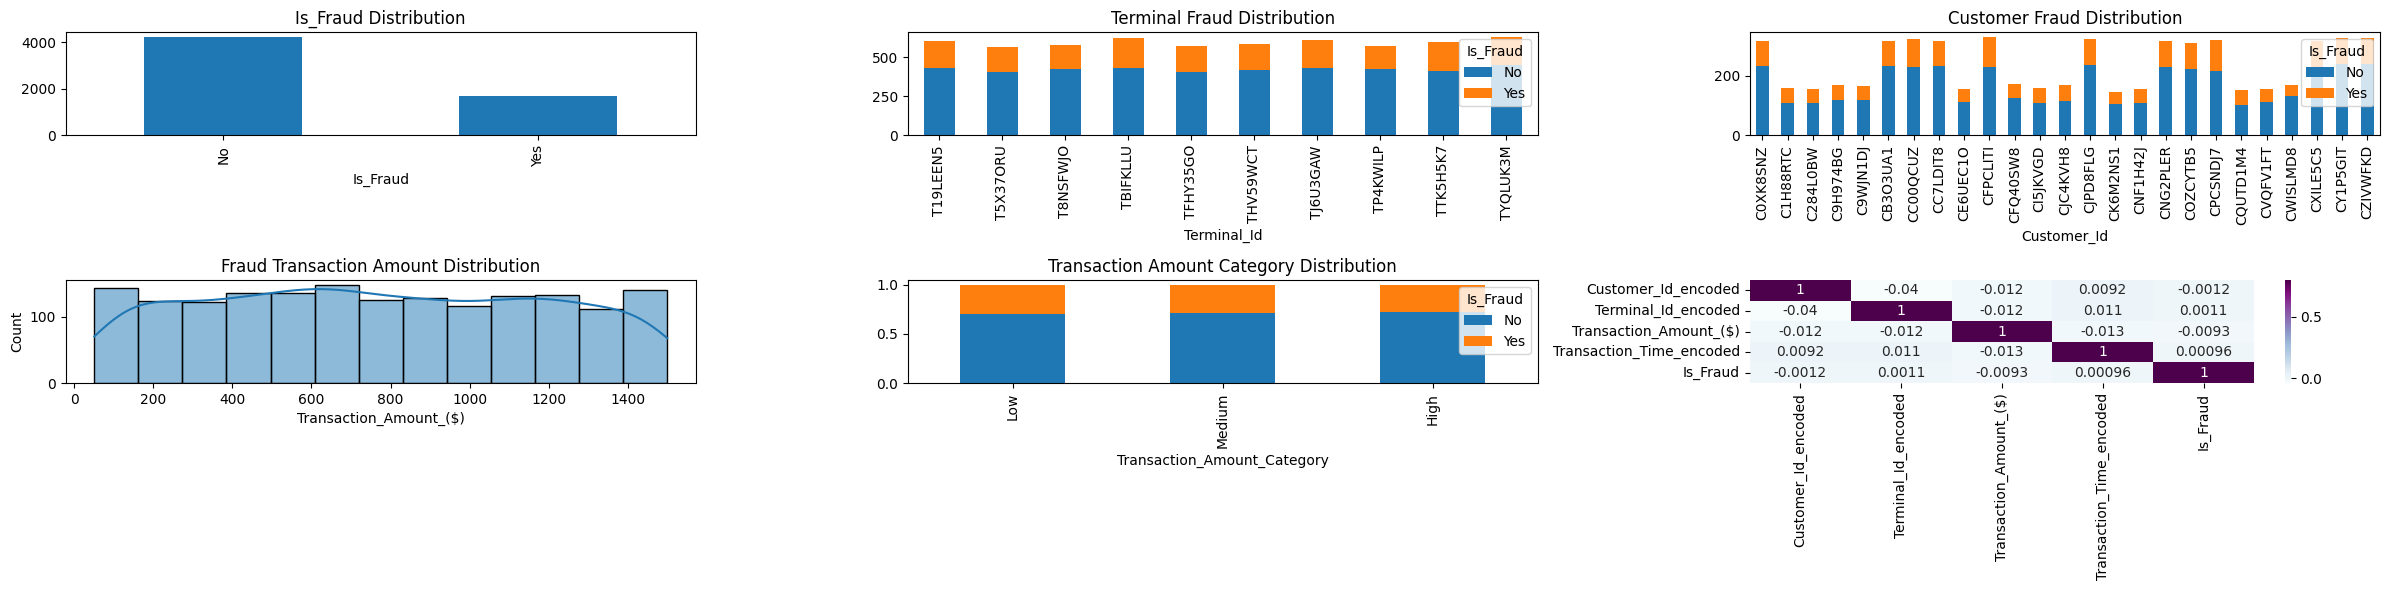

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(24, 6))

training_dataset['Is_Fraud'].value_counts().plot.bar(ax = axes[0, 0], title='Is_Fraud Distribution')

pd.crosstab(training_dataset['Terminal_Id'], training_dataset['Is_Fraud']) \
    .plot(kind='bar', stacked=True, title='Terminal Fraud Distribution', ax=axes[0, 1])

pd.crosstab(training_dataset['Customer_Id'], training_dataset['Is_Fraud']) \
    .plot(kind='bar', stacked=True, title='Customer Fraud Distribution', ax=axes[0, 2])

fraud_data = training_dataset[training_dataset['Is_Fraud'] == 'Yes']
sns.histplot(fraud_data['Transaction_Amount_($)'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Fraud Transaction Amount Distribution')

bins = [0, 500, 1000, 1500]
group = ['Low', 'Medium', 'High']
training_dataset['Transaction_Amount_Category'] = pd.cut(training_dataset['Transaction_Amount_($)'], bins=bins, labels=group)
Transaction_Amount_Bin = pd.crosstab(training_dataset['Transaction_Amount_Category'], training_dataset['Is_Fraud'])
Transaction_Amount_Bin.div(Transaction_Amount_Bin.sum(1).astype(float), axis=0) \
    .plot(kind='bar', stacked=True, title='Transaction Amount Category Distribution', ax=axes[1, 1])

training_dataset['Customer_Id_encoded'] = training_dataset['Customer_Id'].astype('category').cat.codes
training_dataset['Terminal_Id_encoded'] = training_dataset['Terminal_Id'].astype('category').cat.codes
training_dataset['Transaction_Time_encoded'] = pd.to_datetime(training_dataset['Transaction_Time']).dt.hour


data_for_heatmap = training_dataset[['Customer_Id_encoded', 'Terminal_Id_encoded', 'Transaction_Amount_($)', 'Transaction_Time_encoded']].copy()
data_for_heatmap['Is_Fraud'] = training_dataset['Is_Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)
matrix = data_for_heatmap.corr()
sns.heatmap(matrix, annot=True, vmax=".8", cmap='BuPu', ax=axes[1, 2])


plt.tight_layout()
plt.show()

In [24]:
print(training_dataset['Is_Fraud'].value_counts())

# Separate majority and minority classes
df_majority = training_dataset[training_dataset['Is_Fraud'] == 'No']
df_minority = training_dataset[training_dataset['Is_Fraud'] == 'Yes']

# Upsample minority class
df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)

# Combine majority class with upsampled minority class
training_dataset_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset
training_dataset_balanced = training_dataset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(training_dataset_balanced['Is_Fraud'].value_counts())

Is_Fraud
No     4226
Yes    1694
Name: count, dtype: int64
Is_Fraud
Yes    4226
No     4226
Name: count, dtype: int64


In [25]:
## Define the feature columns and create text features for the model
feature_columns = ['Customer_Id', 'Terminal_Id', 'Transaction_Amount_($)', 'Transaction_Time', 'Is_Fraud']

def create_text_features(df):
    cols = feature_columns[:-1]
    df['text'] = df[cols].astype(str).agg(' | '.join, axis=1)
    return df

training_dataset = create_text_features(training_dataset_balanced[feature_columns])
test_dataset = create_text_features(test_dataset[feature_columns])

# Encode the labels
label_encoder = LabelEncoder()
training_dataset = training_dataset.dropna(subset=['Is_Fraud'])
training_dataset['label'] = label_encoder.fit_transform(training_dataset['Is_Fraud']) # 0 for 'No', 1 for 'Yes'

# Convert the DataFrame to a Distilbert dataset
train_model_dataset = Dataset.from_pandas(training_dataset[["text", "label"]])
test_model_dataset = Dataset.from_pandas(test_dataset[["text"]])


In [26]:
# Load the DistilBERT tokenizer and model
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the datasets
train_model_dataset = train_model_dataset.map(tokenize_function, batched=True).shuffle()
test_model_dataset = test_model_dataset.map(tokenize_function, batched=True).shuffle()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8452 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

In [27]:
# Evaluation metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall": recall.compute(predictions=preds, references=labels)["recall"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"],
    }

# Training args
training_args = TrainingArguments(
    output_dir="./fraud_output",
    eval_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_model_dataset,
    eval_dataset=test_model_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [28]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.695900,No log
2,0.694600,No log
3,0.693100,No log


TrainOutput(global_step=3171, training_loss=0.6954176682322155, metrics={'train_runtime': 1844.923, 'train_samples_per_second': 13.744, 'train_steps_per_second': 1.719, 'total_flos': 3358843360321536.0, 'train_loss': 0.6954176682322155, 'epoch': 3.0})

In [33]:
import json
# Evaluate on train set (optional full report)
train_preds = trainer.predict(train_model_dataset)
pred_labels = np.argmax(train_preds.predictions, axis=1)
true_labels = train_model_dataset["label"]
report = classification_report(true_labels, pred_labels, output_dict=True)
with open("eval_metrics.json", "w") as f:
    json.dump(report, f, indent=2)

In [30]:
# Predict on test set
test_preds = trainer.predict(test_model_dataset)
test_labels = np.argmax(test_preds.predictions, axis=1)
test_dataset["Predicted_Is_Fraud"] = label_encoder.inverse_transform(test_labels)

print(test_dataset)

     Customer_Id Terminal_Id  Transaction_Amount_($)     Transaction_Time  \
7247    CC7LDIT8    TBIFKLLU                  854.50  2025-05-12 11:00:00   
1555    CNG2PLER    T8NSFWJO                  373.97  2025-05-12 12:00:00   
6690    CPCSNDJ7    TYQLUK3M                  644.78  2025-05-12 17:00:00   
3190    COZCYTB5    TYQLUK3M                  575.61  2025-05-12 22:00:00   
4566    CC00QCUZ    T5X37ORU                  313.42  2025-05-12 10:00:00   
...          ...         ...                     ...                  ...   
5191    CFQ40SW8    TTK5H5K7                 1283.84  2025-05-12 06:00:00   
5226    CVQFV1FT    TYQLUK3M                 1005.48  2025-05-12 13:00:00   
5390    CJPD8FLG    TJ6U3GAW                   60.25  2025-05-12 16:00:00   
860     CPCSNDJ7    TJ6U3GAW                  592.76  2025-05-12 14:00:00   
7270    C0XK8SNZ    T8NSFWJO                  352.38  2025-05-12 09:00:00   

     Is_Fraud                                               text  \
7247   

In [31]:
print(training_dataset['Is_Fraud'].value_counts())


Is_Fraud
Yes    4226
No     4226
Name: count, dtype: int64


In [32]:
# Save the model and tokenizer
MODEL_ID = "distilbert-base-uncased-fraud-classifer"
model.save_pretrained(MODEL_ID)
tokenizer.save_pretrained(MODEL_ID)

('distilbert-base-uncased-fraud-classifer/tokenizer_config.json',
 'distilbert-base-uncased-fraud-classifer/special_tokens_map.json',
 'distilbert-base-uncased-fraud-classifer/vocab.txt',
 'distilbert-base-uncased-fraud-classifer/added_tokens.json',
 'distilbert-base-uncased-fraud-classifer/tokenizer.json')

In [36]:
from huggingface_hub import upload_file, notebook_login

notebook_login()

 # Push to Hugging Face Hub
ORG_NAME = "ModSpecialization"
REPO_NAME = "distilbert-base-uncased-fraud-classifer"
FULL_REPO_ID = f"{ORG_NAME}/{REPO_NAME}"

# Create repo under the org
create_repo(repo_id=FULL_REPO_ID, private=False, exist_ok=True)

# Upload model + tokenizer
model.push_to_hub(FULL_REPO_ID)
tokenizer.push_to_hub(FULL_REPO_ID)

# Upload the evaluation metrics JSON
upload_file(
    path_or_fileobj="eval_metrics.json",
    path_in_repo="eval_metrics.json",
    repo_id=FULL_REPO_ID,
    repo_type="model"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ModSpecialization/distilbert-base-uncased-fraud-classifer/commit/1b213b3f0b5cb651a53afab4d193be67864ef7ba', commit_message='Upload eval_metrics.json with huggingface_hub', commit_description='', oid='1b213b3f0b5cb651a53afab4d193be67864ef7ba', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ModSpecialization/distilbert-base-uncased-fraud-classifer', endpoint='https://huggingface.co', repo_type='model', repo_id='ModSpecialization/distilbert-base-uncased-fraud-classifer'), pr_revision=None, pr_num=None)

In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder

MODEL_ID = "ModSpecialization/distilbert-base-uncased-fraud-classifer"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["No", "Yes"])

def classify_fraud(customer_id, terminal_id, amount, timestamp):
    text = f"{customer_id} | {terminal_id} | {amount} | {timestamp}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    pred = np.argmax(outputs.logits.detach().numpy(), axis=1)
    print(pred)

    return f"Prediction: {label_encoder.inverse_transform(pred)[0]}"


In [53]:
print(classify_fraud("C12345", "T67890", 1500, "2023-10-01 12:00:00"))

[1]
Prediction: Yes
